In [1]:
#!pip install matplotlib
#!pip install seaborn
#!pip install -U scikit-learn
#!pip install opencv-python
#!pip install h5py
#!pip install pydot
#!pip install graphviz

In [2]:
# Import packages and dependencies 
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style= "darkgrid", color_codes = True)
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input
from keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing.image import  load_img
import warnings
import glob
import cv2
import pandas as pd
from sklearn.metrics import classification_report
warnings.filterwarnings('ignore')
import h5py
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
#import pickle

In [3]:
# Since these scripts were developed using Windows native Anaconda environment, the highest available tensorflow version is 2.10 for windows
# This also uses Python version 3.10, CUDA Toolkit Version 11.8 and CUDNN version 8.6
# This program uses GPU version of Tensorflow to speed up the trianing of the models.
# Install links were followed from this site: https://www.tensorflow.org/install/pip

# Check Tensorflow Version used 
print(tf.__version__)

#tf.test.is_gpu_available()
tf.config.list_physical_devices('GPU')

2.10.1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# Define image size and other parameters
# There are three image files - Train, Test, and Validation, each comprising of two sudirectorties labelled as Normal and Pneumonia 
# Normal Subdirectories contain images of patients with no Pneumonia symtptoms
# Prenumonia subdirectories contain images of patients with Pneumonia symptoms

# Set initial values for the variables.
img_width, img_height = 256, 256
batchsize = 32
epochs = 4
num_of_class = 2


In [5]:
# Read Validation image data sets
# The keras.utils.image_dataset_from_directory function is designed to load images from a directory and generate a dataset suitable for training 
# or validation in a machine learning model.It handles loading the images, inferring the labels, resizing the images, batching them, and ensuring 
# the process is reproducible with a fixed random seed.

validation = keras.utils.image_dataset_from_directory(
    directory='Resources/val',
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    # color_mode='grayscale',
    image_size=(img_width, img_height),
    seed=123)

Found 16 files belonging to 2 classes.


In [6]:
# Read Test image data sets
test = keras. utils.image_dataset_from_directory(
    directory='Resources/test',
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    # color_mode='grayscale',
    image_size=(img_width, img_height),
    seed=123)

Found 624 files belonging to 2 classes.


In [7]:
# Read Training image data sets
train = keras. utils.image_dataset_from_directory(
    directory='Resources/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    # color_mode='grayscale',
    image_size=(img_width, img_height),
    seed=123)

Found 5216 files belonging to 2 classes.


In [8]:
# Check image classes. These will be used as Target Variables during training
print(f'Training Image Labels: {train.class_names}')
print(f'Validation Image Labels: {validation.class_names}')
print(f'Testing Image Labels: {test.class_names}')

Training Image Labels: ['NORMAL', 'PNEUMONIA']
Validation Image Labels: ['NORMAL', 'PNEUMONIA']
Testing Image Labels: ['NORMAL', 'PNEUMONIA']


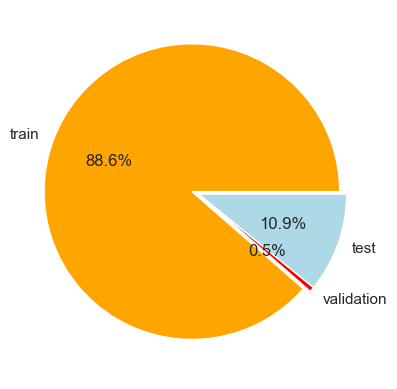

In [9]:
# Check Data Distribution across three data sets: Train, Test, and Validation
plt.pie([len(train), len(validation), len(test)],
        labels=['train', 'validation', 'test'], autopct='%.1f%%', colors=['orange', 'red', 'lightblue'], explode=(0.05, 0, 0))
plt.show()

In [10]:
# Transform the training data from a TensorFlow dataset format into a format that is easier to manipulate and use with NumPy, which is a popular 
# numerical computing library in Python. This transformation might be necessary for certain types of preprocessing, analysis, or when interfacing with 
# other libraries that expect NumPy arrays.

# Initialize X_train and y_train as empty lists
x_train = []
y_train = []

# For each batch of data (composed of feature and label pairs), convert the feature and label tensors to NumPy arrays using the .numpy() method 
# and append them to the x_train and y_train lists, respectively. Previously the data was read into a TensorFlow dataset object.

for feature, label in train:
    x_train.append(feature.numpy())
    y_train.append(label.numpy())

# Merge all the feature arrays in x_train and label arrays in y_train along the first axis (batch axis) into respective single NumPy arrays.
x_train = np.concatenate(x_train, axis=0)
y_train_np = np.concatenate(y_train, axis=0)


In [11]:
# Reduce the training sample for testing algorithm. This is not needed for the final solution. Hence Commented
#x_train_sample=x_train[0:100]
#y_train_sample=y_train_np[0:100]

In [12]:
# Convert Validation data images into a numpy array similar to training dataset
x_val = []
y_val = []
    
for feature, label in validation:
    x_val.append(feature.numpy())
    y_val.append(label.numpy())

x_val = np.concatenate(x_val, axis=0)
y_val_np = np.concatenate(y_val, axis=0)


In [13]:
# Convert Validation data images into a numpy array similar to training dataset
x_test = []
y_test = []

for feature, label in test:
    x_test.append(feature.numpy())
    y_test.append(label.numpy())

x_test = np.concatenate(x_test, axis=0)
y_test_np = np.concatenate(y_test, axis=0)


Class names: ['NORMAL', 'PNEUMONIA']
Image batch shape: (16, 256, 256, 3)
Label batch shape: (16, 2)
Labels (one-hot): [[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]
--------------------------------------
Sample Images


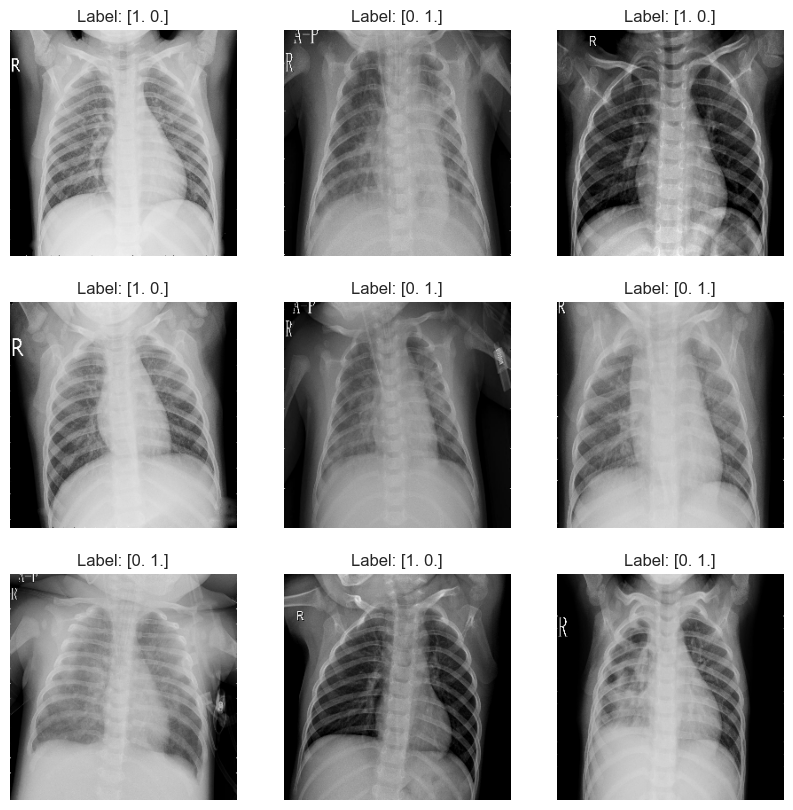

In [14]:
# Explore and visualize a batch of images from a validation dataset created using TensorFlow's keras.utils.image_dataset_from_directory function. 
# This step retrieves and prints the class names, displays the shape of the image and label batches, prints one-hot encoded labels, and visualizes some of the
# images along with their labels.

class_names = validation.class_names
print("Class names:", class_names)


# Inspect first batch of data; print shapes of images and labels; convert labels using one-hot encoder from numpy.

for images, labels in validation.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    print("Labels (one-hot):", labels.numpy())

print ("--------------------------------------")
print ("Sample Images")

# Display some images and their one-hot encoded labels

plt.figure(figsize=(10, 10))

for images, labels in validation.take(1):                    
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")

plt.show()

In [15]:
# check the shapes of 'x_train' and 'y_train':
print("Shape of 'x_train':", x_train.shape)
print("Shape of 'y_train_np':", y_train_np.shape)
print("Shape of 'x_val':", x_val.shape)
print("Shape of 'y_val_np':", y_val_np.shape)
print("Shape of 'x_test':", x_test.shape)
print("Shape of 'y_test_np':", y_test_np.shape)

Shape of 'x_train': (5216, 256, 256, 3)
Shape of 'y_train_np': (5216, 2)
Shape of 'x_val': (16, 256, 256, 3)
Shape of 'y_val_np': (16, 2)
Shape of 'x_test': (624, 256, 256, 3)
Shape of 'y_test_np': (624, 2)


In [16]:
# Normalize dataset images by divding by 255
# Deep learning models often work better with data normalized to a smaller range, usually between 0 and 1. This normalization helps the model learn 
# more effectively and converge faster.

x_train=x_train/255
x_val=x_val/255
x_test=x_test/255

In [17]:
# We use transfer learning with VGG16 as the base model, a model designed at University of Oxford University by Karen Simonyan and Andrew Zisserman 
# from the Visual Geometry Group (VGG). VGG16 is a convolutional neural network architecture known for its simplicity and strong performance in image 
# classification. It achieves high accuracy by using many small convolutional filters (3x3) stacked together in increasing depth (16 layers). 
# VGG16 is pre-trained on a massive dataset (ImageNet) and can be used for various tasks through transfer learning. 

# The below code sets the trainable attribute of each layer to False, effectively freezing the weights and preventing them from being updated during training.
# This helps to leverage the learned features from ImageNet while focusing training on your specific classification task. 
# "include_top=False", excludes the final classification layers pre-trained on ImageNet. These layers are typically designed for the 1000-class ImageNet 
# dataset and wouldn't be suitable for our task with only 2 classes.

def CNN_Model():
    # define base model
    base_model = VGG16(weights='imagenet', include_top = False, input_shape=(img_width, img_height, 3))
    
    # Freeze the base model
    for layer in base_model.layers:
        layer.trainable = False
    
    # Make the last three layers trainable where we can add our own modifications to the hiddent layers and output layers.
    for i in range(3):
        base_model.layers[-2-i].trainable = True
    CNN = Sequential()
    CNN.add(Input(shape=(img_width, img_height,3)))
    CNN.add(base_model)
    CNN.add(Flatten())
    CNN.add(Dropout(0.3))
    CNN.add(Dense(128, activation='relu', kernel_regularizer=l2(0.05)))
    CNN.add(Dropout(0.2))
    CNN.add(Dense(2, activation='sigmoid'))
    return CNN

# Training The CNN
model = CNN_Model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dropout (Dropout)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 128)               4194432   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 18,909,378
Trainable params: 11,274,114
No

In [18]:
# train the model on the training data; use validation data for monitoring model performance during training

hist = model.fit(x_train, y_train_np, epochs= 6, validation_data= (x_val, y_val_np))
print(hist.history)

# print best validaiton score achieved during the training
best_score = max(hist.history['val_accuracy'])
print(f"Best Validation score is: {best_score}")

Epoch 1/6
163/163 [==============================] - 20s 85ms/step - loss: 1.0671 - accuracy: 0.9051 - val_loss: 0.1021 - val_accuracy: 1.0000
Epoch 2/6
163/163 [==============================] - 13s 77ms/step - loss: 0.1403 - accuracy: 0.9699 - val_loss: 0.1916 - val_accuracy: 0.9375
Epoch 3/6
163/163 [==============================] - 13s 78ms/step - loss: 0.1369 - accuracy: 0.9724 - val_loss: 0.5603 - val_accuracy: 0.7500
Epoch 4/6
163/163 [==============================] - 13s 78ms/step - loss: 0.0886 - accuracy: 0.9827 - val_loss: 0.0822 - val_accuracy: 1.0000
Epoch 5/6
163/163 [==============================] - 13s 78ms/step - loss: 0.0834 - accuracy: 0.9852 - val_loss: 0.0494 - val_accuracy: 1.0000
Epoch 6/6
163/163 [==============================] - 13s 77ms/step - loss: 0.0587 - accuracy: 0.9885 - val_loss: 0.2848 - val_accuracy: 0.9375
{'loss': [1.0671418905258179, 0.14032268524169922, 0.136872336268425, 0.08856585621833801, 0.0833856612443924, 0.05873510614037514], 'accuracy

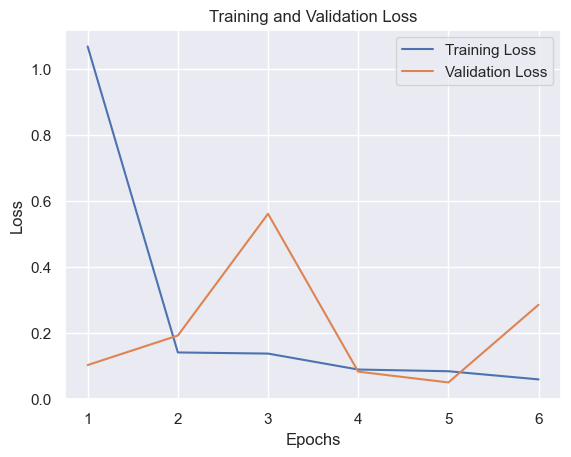

In [19]:
# Extract the training and validation loss values from the history object
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

# Create a list of epoch numbers (1 to number of epochs)
epochs = range(1, len(train_loss) + 1)

# Plot the loss graph
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

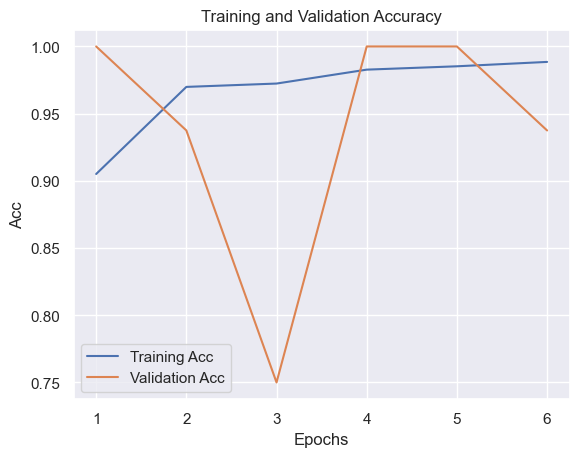

In [20]:
# Extract the training and validation loss values from the history object
train_accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

# Create a list of epoch numbers (1 to number of epochs)
epochs = range(1, len(train_accuracy) + 1)

# Plot the loss graph
plt.plot(epochs, train_accuracy , label='Training Acc')
plt.plot(epochs, val_accuracy, label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# evaluate the performance of trained CNN model on unseen test data (x_test) and compare it against y_test_np, the target labels
model.evaluate(x_test, y_test_np)

20/20 [==============================] - 1s 66ms/step - loss: 1.8379 - accuracy: 0.7340


[1.8379297256469727, 0.7339743375778198]

In [22]:
# make predictions on new, unseen test data
x_test_predict=model.predict(x_test)
print(x_test_predict.shape)

# identify the most likely class for each sample in the test data.
pred_final=np.argmax(x_test_predict,axis=1)
print(pred_final.shape)


20/20 [==============================] - 1s 62ms/step
(624, 2)
(624,)


In [23]:
# show contents of pred_final
pred_final

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [24]:
img_test=[]
label_test=[]
for image_batch,label_batch in test:
  img_test.append(image_batch)
  label_test.append(label_batch)
inputs_test=np.concatenate(img_test)
targets_test=np.concatenate(label_test)
print(inputs_test.shape)
print(targets_test.shape)
print(targets_test)

(624, 256, 256, 3)
(624, 2)
[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [1. 0.]]


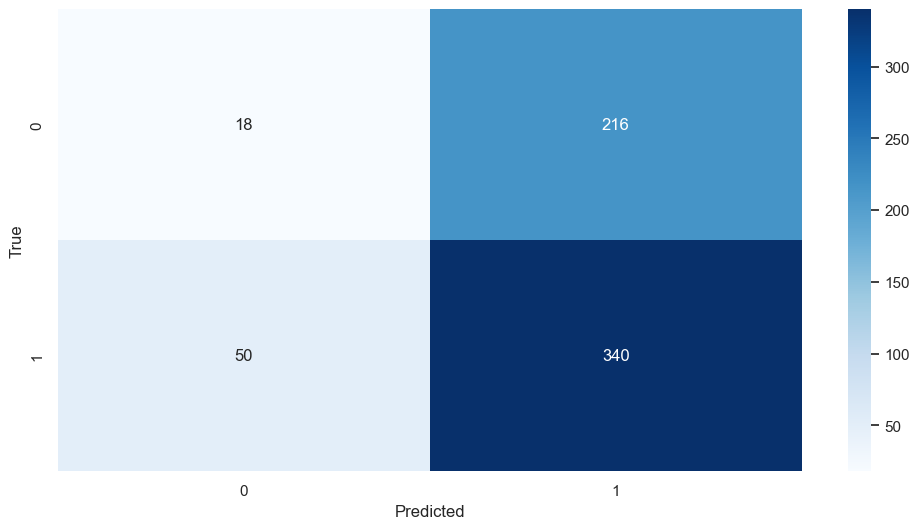

In [25]:
# Convert predictions to class indices if necessary
if pred_final.ndim > 1 and pred_final.shape[1] > 1:
    pred_final = np.argmax(pred_final, axis=1)

# Ensure targets_test is in the correct format; It should already be, but double-check to avoid errors
if targets_test.ndim > 1 and targets_test.shape[1] > 1:
    targets_test = np.argmax(targets_test, axis=1)

# Generate a confusion matrix for the test dataset
cm = tf.math.confusion_matrix(labels=targets_test, predictions=pred_final)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=[12, 6])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [26]:
# Calculate classification report
report = classification_report(y_true=targets_test, y_pred=pred_final)

# Print classification report
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.26      0.08      0.12       234
           1       0.61      0.87      0.72       390

    accuracy                           0.57       624
   macro avg       0.44      0.47      0.42       624
weighted avg       0.48      0.57      0.49       624



In [27]:
# Recommendations:
# The Model has high recall (senstivity), but low precision, resulting has higher false positives.The model should be trained by augmentation method, 
# or by fixing the imbalance between normal and Pneumonia datasets
